In [49]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.io import fits
from __future__ import print_function
%matplotlib inline

In [50]:
datacube = fits.getdata('./data/Eagle_final_m96_m93_m83_m65.fits')
datacube.shape

(6000, 26, 143)

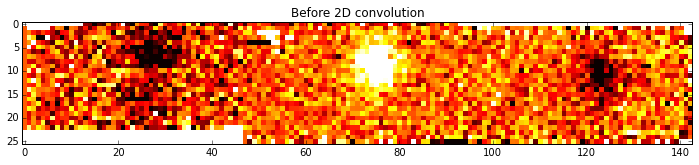

In [58]:
fig, ax = plt.subplots(figsize=(12, 16))
data = datacube[3358, :, :]
ax.imshow(data, cmap=cm.hot, vmin=-10, vmax=10, interpolation='nearest')
ax.set_title('Before 2D convolution')

In [52]:
from astropy.convolution import convolve, Box2DKernel, Tophat2DKernel, MexicanHat2DKernel, Ring2DKernel,\
    TrapezoidDisk2DKernel, AiryDisk2DKernel
gauss_kernel = Gaussian2DKernel(0.75)
tophat_kernel = Tophat2DKernel(2.5)
airy_kernel = AiryDisk2DKernel(2.5)
print('Gaussian kernel shape: ', gauss_kernel.shape)
print('Tophat kernel shape:', tophat_kernel.shape)
print('Airy disk kernel shape:', airy_kernel.shape)
data_gauss_convolved = convolve(data, gauss_kernel)
data_tophat_convolved = convolve(data, tophat_kernel)
data_airy_convolved = convolve(data, airy_kernel)

Gaussian kernel shape:  (7, 7)
Tophat kernel shape: (5, 5)
Airy disk kernel shape: (21, 21)


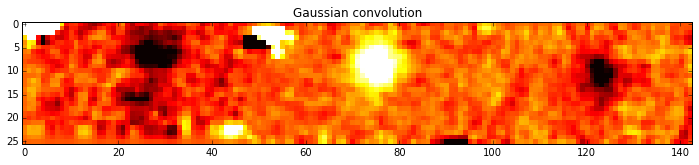

In [53]:
fig, ax = plt.subplots(figsize=(12, 16))
ax.imshow(data_gauss_convolved, cmap=cm.hot, vmin=-10, vmax=10, interpolation='nearest')
ax.set_title('Gaussian convolution')

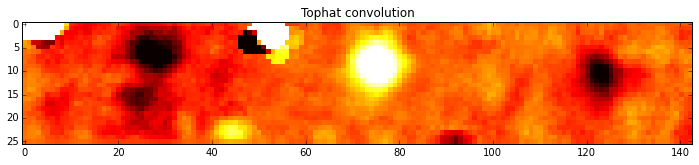

In [54]:
fig, ax = plt.subplots(figsize=(12, 16))
ax.imshow(data_tophat_convolved, cmap=cm.hot, vmin=-10, vmax=10, interpolation='nearest')
ax.set_title('Tophat convolution')

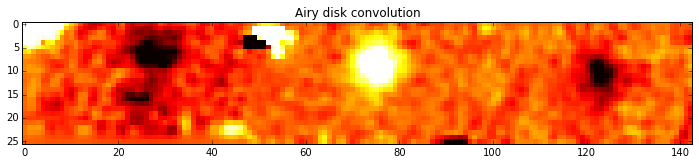

In [55]:
fig, ax = plt.subplots(figsize=(12, 16))
ax.imshow(data_airy_convolved, cmap=cm.hot, vmin=-10, vmax=10, interpolation='nearest')
ax.set_title('Airy disk convolution')